# How to train your DragoNN tutorial 1: 
## Exploring convolutional neural network (CNN) architectures for simulated genomic data

This tutorial is a supplement to the DragoNN manuscript and follows figure 5 in the manuscript. 

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Review of patterns in transcription factor binding sites</a></li>
    <li><a href=#3>Learning to localize homotypic motif density</a></li>
    <li><a href=#4>Simulate training data with simdna</a></li>  
    <li><a href=#5>Defining CNN architecture</a></li>
    <li><a href=#6>Single layer, single filter model</a></li>
    <li><a href=#7>Single layer, multiple filter model</a></li>
    <li><a href=#8>Model Interpretation</a></li>    
    <li><a href=#9>Multi-layer model</a></li>
    <li><a href=#10>Regularized multi-layer model</a></li>
    <li><a href=#11>Further exploration</a></li>
    <li><a href=#12>Using DragoNN with your own non-simulated data</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [1]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#!pip install tensorflow-gpu==1.6
#!pip install keras==2.2

from dragonn.tutorial_utils import *


/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Key properties of regulatory DNA sequences <a name='2'>
<a href=#outline>Home</a>

![sequence properties 1](./primer_tutorial_images/sequence_properties_1.jpg)
![sequence properties 2](./primer_tutorial_images/sequence_properties_2.jpg)

## Learning to localize homotypic motif density <a name='3'>
<a href=#outline>Home</a>

In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![homotypic motif density localization](./primer_tutorial_images/homotypic_motif_density_localization.jpg)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

![classificatioin task](./tutorial_images/homotypic_motif_density_localization_task.jpg)

We start by getting the simulation data.

## Getting simulation data <a name='4'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. We will use the **simulate_motif_density_localization** function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [2]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [3]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the **get_simulation_data** function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

In [4]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
<img src="tutorial_images/one_hot_encoding.png" width="500">

Here are the first 10bp of a sequence in our training data:

In [5]:
simulation_data.X_train[0, :, :10, :]

array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]], dtype=int32)

We can convert this one-hot-encoded matrix back into a DNA string:

In [6]:
from dragonn.utils import *
get_sequence_strings(simulation_data.X_train)[0][:10]

b'AAGTGCAAAA'

Let's examine the shape of training, validation, and test matrices: 

In [7]:
print(simulation_data.X_train.shape)
print(simulation_data.y_train.shape)

(4000, 1, 1500, 4)
(4000, 1)


In [8]:
print(simulation_data.X_valid.shape)
print(simulation_data.y_valid.shape)

(1000, 1, 1500, 4)
(1000, 1)


In [9]:
print(simulation_data.X_test.shape)
print(simulation_data.y_test.shape)

(1000, 1, 1500, 4)
(1000, 1)


# Defining the convolutional neural network model architecture  <a name='5'>
<a href=#outline>Home</a>

A locally connected linear unit in a CNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thresholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a CNN model with tiled, locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thresholding and maxpooling (part c).
![dragonn vs pssm](./tutorial_images/dragonn_and_pssm.jpg)
By utilizing multiple convolutional layers with multiple convolutional filters, CNN's can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](./tutorial_images/dragonn_model_figure.jpg)

We will use the deep learning library [keras](http://keras.io/) with the [TensorFlow](https://github.com/tensorflow/tensorflow) backend to generate and train the CNN models. 

In [10]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


Using TensorFlow backend.


# Single layer, single filter model <a name='6'>
<a href=#outline>Home</a>


We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 
The model parameters are: 

* input sequence length 1500 
* 1 filter 
* convolutional kernels of width 10 
* max pool of width 35 


In [11]:
#Define the model architecture in keras
one_filter_keras_model=Sequential() 
one_filter_keras_model.add(Conv2D(filters=1,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(1))
one_filter_keras_model.add(Activation("sigmoid"))

In [12]:
one_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1491, 1)        41        
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1491, 1)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 42, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Making sure our results are reproducible
# The model is namely initialized using random weights
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [14]:
##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
one_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

We train the model for 150 epochs, with an early stopping criterion -- if the loss on the validation set does not improve for five consecutive epochs, the training is halted. In each epoch, the one_filter_dragonn performed a complete pass over the training data, and updated its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the performance metrics for the one_filter_dragonn on the validation data were stored. 

The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [15]:
from dragonn.callbacks import * 
#We define a custom callback to print training and validation metrics while training. 
metrics_callback=MetricsCallback(train_data=(simulation_data.X_train,simulation_data.y_train),
                                 validation_data=(simulation_data.X_valid,simulation_data.y_valid))


In [16]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_one_filter=one_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 7s 2ms/step - loss: 0.9406 - val_loss: 0.7330
Training Data:
Loss: 0.7180	Balanced Accuracy: 49.67%	 auROC: 0.488	 auPRC: 0.478
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7330	Balanced Accuracy: 50.02%	 auROC: 0.486	 auPRC: 0.527
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 74us/step - loss: 0.7068 - val_loss: 0.7045
Training Data:
Loss: 0.7071	Balanced Accuracy: 49.53%	 auROC: 0.490	 auPRC: 0.479
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7045	Balanced Accuracy: 47.43%	 auROC: 0.485	 auPRC: 0.527
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 68us/step - loss: 0.7

### Evaluate the model on the held-out test set 

In [17]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=one_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.6974	Balanced Accuracy: 51.03%	 auROC: 0.519	 auPRC: 0.544
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 515	 Num Negatives: 485


### Visualize the model's performance

We can see that the validation loss is not decreasing and the auROC metric is not decreasing, which indicates this model is not learning. A simple plot of the learning curve, showing the loss function on the training and validation data over the course of training, demonstrates this visually:

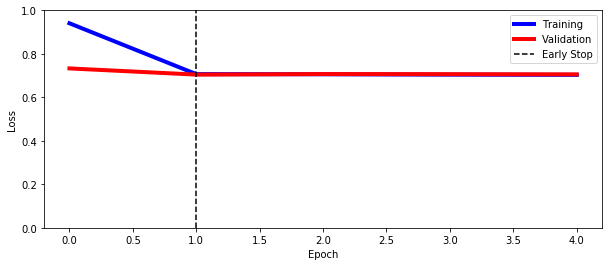

In [18]:
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_one_filter)

## Visualize the learned parameters 

Next, let's visualize the filter learned in this model

### Dense layer

In [19]:
W_dense, b_dense = one_filter_keras_model.layers[-2].get_weights()

In [20]:
b_dense

array([0.03257668], dtype=float32)

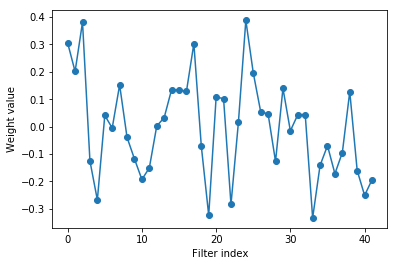

In [21]:
plt.plot(W_dense, "-o")
plt.xlabel("Filter index")
plt.ylabel("Weight value");

### Convolutional layer 

In [22]:
W_conv, b_conv = one_filter_keras_model.layers[0].get_weights()

In [23]:
W_conv.shape

(1, 10, 4, 1)

In [24]:
b_conv.shape

(1,)

Plotting simulation motifs...


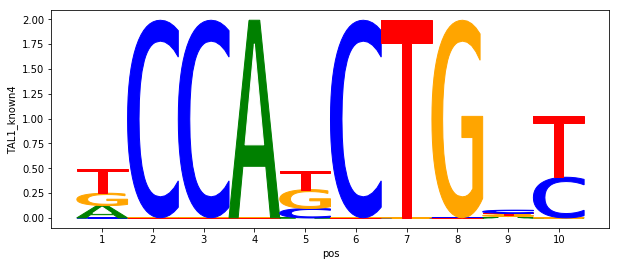

Visualizing convolutional sequence filters in SequenceDNN...


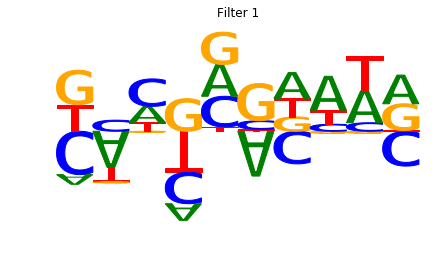

In [25]:
from dragonn.tutorial_utils import interpret_filters

interpret_filters(one_filter_keras_model, simulation_data)

# A multi-filter DragoNN model <a name='7'>
<a href=#outline>Home</a>

Next, we modify the model to have 15 convolutional filters instead of just one filter. Will the model learn now?

In [26]:
#Define the model architecture in keras
multi_filter_keras_model=Sequential() 
multi_filter_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_filter_keras_model.add(Activation('relu'))
multi_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
multi_filter_keras_model.add(Flatten())
multi_filter_keras_model.add(Dense(1))
multi_filter_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [27]:
multi_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 630)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 631       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,246
Trainable params: 1,246
Non-trainable params: 0
_________________________________________________________________


In [28]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_filter=one_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 0s 110us/step - loss: 0.7026 - val_loss: 0.7048
Training Data:
Loss: 0.7017	Balanced Accuracy: 50.52%	 auROC: 0.499	 auPRC: 0.486
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7048	Balanced Accuracy: 49.56%	 auROC: 0.486	 auPRC: 0.528
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 73us/step - loss: 0.7015 - val_loss: 0.7040
Training Data:
Loss: 0.7008	Balanced Accuracy: 50.92%	 auROC: 0.501	 auPRC: 0.488
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7040	Balanced Accuracy: 48.48%	 auROC: 0.486	 auPRC: 0.528
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 80us/step - loss: 0

4000/4000 [==============================] - 0s 80us/step - loss: 0.6932 - val_loss: 0.6948
Training Data:
Loss: 0.6920	Balanced Accuracy: 51.11%	 auROC: 0.528	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6948	Balanced Accuracy: 50.20%	 auROC: 0.513	 auPRC: 0.550
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 528	 Num Negatives: 472
Epoch 21/150
4000/4000 [==============================] - 0s 75us/step - loss: 0.6922 - val_loss: 0.6998
Training Data:
Loss: 0.6925	Balanced Accuracy: 51.24%	 auROC: 0.528	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6998	Balanced Accuracy: 50.06%	 auROC: 0.514	 auPRC: 0.550
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 528	 Num Negatives: 472
Epoch 22/150
4000/4000 [==============================] - 0s 74us/step - loss: 0.6925 - val_loss: 0.6929
Training Data:
Loss: 0.6926	Balanc

In [29]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.8347	Balanced Accuracy: 50.00%	 auROC: 0.464	 auPRC: 0.496
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 515	 Num Negatives: 485


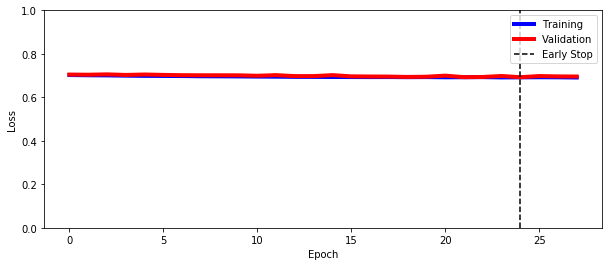

In [30]:
## Visualize the model's performance 
plot_learning_curve(history_multi_filter)

Plotting simulation motifs...


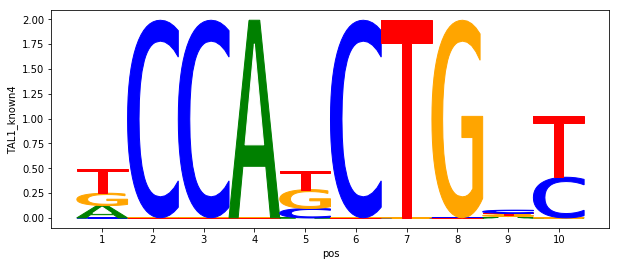

Visualizing convolutional sequence filters in SequenceDNN...


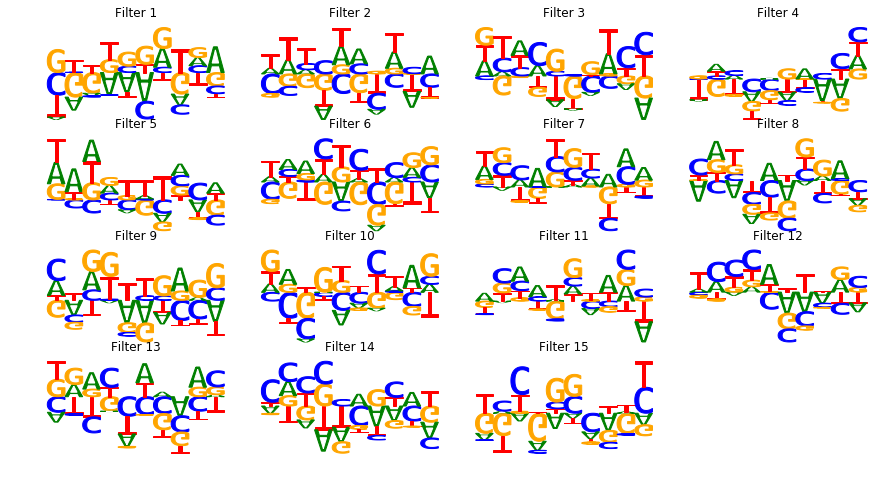

In [31]:
## Visualize the motifs learned by the model
interpret_filters(multi_filter_keras_model, simulation_data)

# Model Interpretation <a name='8'>
<a href=#outline>Home</a>


As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

Let's examine a positive and negative example from our simulation data:

In [32]:
#get the indices of the first positive and negative examples in the validation data split
pos_indx=np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X=simulation_data.X_valid[pos_indx:pos_indx+1]

neg_indx=np.flatnonzero(simulation_data.y_valid==0)[0]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

2
0


### Motif Scores

In [33]:
pos_motif_scores=get_motif_scores(pos_X,simulation_data.motif_names,return_positions=True).squeeze()
neg_motif_scores=get_motif_scores(neg_X,simulation_data.motif_names,return_positions=True).squeeze()

Text(0.5, 1.0, 'Positive example')

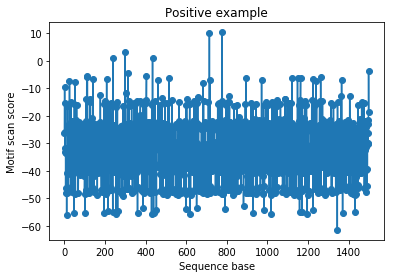

In [34]:
plt.plot(pos_motif_scores, "-o")
plt.xlabel("Sequence base")
plt.ylabel("Motif scan score")
plt.title("Positive example")


Text(0.5, 1.0, 'Negative example')

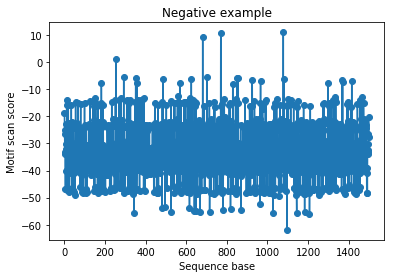

In [35]:
plt.plot(neg_motif_scores, "-o")
plt.xlabel("Sequence base")
plt.ylabel("Motif scan score")
plt.title("Negative example")


The motif scan yields a group of three high-scoring motif alignment positions at a fixed distance near the center of the sequence in the positive example. The spacing of the high-scoring motif alignments is random in the negative sequence. 

### In silico mutagenesis 

To determine how much each position in the input sequence contrinbutes to the model's prediction, we can perform saturation mutagenesis on the sequence. For each position in the input sequence, we introduce each of the four possible bases A, C, G, T and quantify the effect on the model's predictions.

In [36]:
from dragonn.tutorial_utils import in_silico_mutagenesis
ism_pos=in_silico_mutagenesis(multi_filter_keras_model,pos_X).squeeze()
ism_neg=in_silico_mutagenesis(multi_filter_keras_model,neg_X).squeeze()

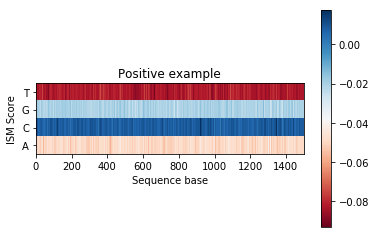

In [37]:
# create discrete colormap of ISM scores 
extent = [0, ism_pos.shape[0], 0, 100*ism_pos.shape[1]]
plt.imshow(ism_pos.T,extent=extent)
plt.xlabel("Sequence base")
plt.ylabel("ISM Score")
plt.title("Positive example")
plt.yticks(np.arange(50,100*ism_pos.shape[1],100),("A","C","G","T"))
plt.set_cmap('RdBu')
plt.colorbar()
plt.show()

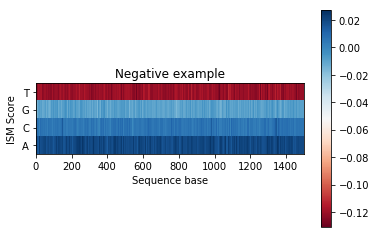

In [38]:
# create discrete colormap of ISM scores 
extent = [0, ism_neg.shape[0], 0, 100*ism_neg.shape[1]]
plt.imshow(ism_neg.T,extent=extent)
plt.xlabel("Sequence base")
plt.ylabel("ISM Score")
plt.title("Negative example")
plt.yticks(np.arange(50,100*ism_pos.shape[1],100),("A","C","G","T"))
plt.set_cmap('RdBu')
plt.colorbar()
plt.show()

### DeepLIFT

[DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf) allows us to obtain scores for specific sequence indicating the importance of each position in the sequence. 

In [39]:
from dragonn.tutorial_utils import deeplift 
dl_pos=deeplift(multi_filter_keras_model,pos_X)

ValueError: You are tring to use the old GPU back-end. It was removed from Theano. Use device=cuda* now. See https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29 for more information.

In [ ]:
multi_filter_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15], ## notice the change from 1 filter to 15 filters
    'conv_width': [10],
    'pool_width': 35}
multi_filter_dragonn = SequenceDNN.load("primer_tutorial_models/multi_filter_dragonn.arch.json",
                                           "primer_tutorial_models/multi_filter_dragonn.weights.h5")
with open('primer_tutorial_models/multi_filter_dragonn.train_metrics.pkl', 'rb') as handle:
    multi_filter_dragonn.train_metrics = pickle.load(handle,encoding="latin1")
with open('primer_tutorial_models/multi_filter_dragonn.valid_metrics.pkl', 'rb') as handle:
    multi_filter_dragonn.valid_metrics = pickle.load(handle,encoding="latin1")
SequenceDNN_learning_curve(multi_filter_dragonn)
test_SequenceDNN(multi_filter_dragonn, simulation_data)

It slightly outperforms the single filter model and exhibits some overfitting. Let's check if the learned filters capture the simulated pattern.

In [ ]:
interpret_SequenceDNN_filters(multi_filter_dragonn, simulation_data)

Only some of the filters closesly match the simulated pattern. This illustrates that interpreting model parameters directly works partially for multi-filter models.

# A multi-layer DragoNN model <a name='8'>
Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

In [ ]:
multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15], ## notice the change to multiple filter values, one for each layer
    'conv_width': [10, 10, 10],
    'pool_width': 35}
multi_layer_dragonn = SequenceDNN.load("primer_tutorial_models/multi_layer_dragonn.arch.json",
                                           "primer_tutorial_models/multi_layer_dragonn.weights.h5")
with open('primer_tutorial_models/multi_layer_dragonn.train_metrics.pkl', 'rb') as handle:
    multi_layer_dragonn.train_metrics = pickle.load(handle,encoding="latin1")
with open('primer_tutorial_models/multi_layer_dragonn.valid_metrics.pkl', 'rb') as handle:
    multi_layer_dragonn.valid_metrics = pickle.load(handle,encoding="latin1")
SequenceDNN_learning_curve(multi_layer_dragonn)
test_SequenceDNN(multi_layer_dragonn, simulation_data)

This model performs slightly better than the single layer model but it overfits more. We will try to address that with dropout regularization. But first, what do the first layer filters look like?

In [ ]:
interpret_SequenceDNN_filters(multi_layer_dragonn, simulation_data)

The filters now make less sense than in the single layer model case. In multi-layered models, sequence features are learned compositionally across the layers. As a result, sequence filters in the first layer focus more on simple features that can be combined in higher layers to learn motif features more efficiently, and their interpretation becomes less clear based on simple visualizations.

# A regularized multi-layer DragoNN model <a name='9'>
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

In [ ]:
regularized_multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15],
    'conv_width': [10, 10, 10],
    'pool_width': 35,
    'dropout': 0.2} ## we introduce dropout of 0.2 on every convolutional layer for regularization
regularized_multi_layer_dragonn = SequenceDNN.load(
    "primer_tutorial_models/regularized_multi_layer_dragonn.arch.json",
    "primer_tutorial_models/regularized_multi_layer_dragonn.weights.h5")
with open('primer_tutorial_models/regularized_multi_layer_dragonn.train_metrics.pkl', 'rb') as handle:
    regularized_multi_layer_dragonn.train_metrics = pickle.load(handle,encoding="latin1")
with open('primer_tutorial_models/regularized_multi_layer_dragonn.valid_metrics.pkl', 'rb') as handle:
    regularized_multi_layer_dragonn.valid_metrics = pickle.load(handle,encoding="latin1")
SequenceDNN_learning_curve(regularized_multi_layer_dragonn)
test_SequenceDNN(regularized_multi_layer_dragonn, simulation_data)

As expected, dropout decreased the overfitting this model displayed previously and increased test performance. Let's see the learned filters.

In [ ]:
interpret_SequenceDNN_filters(regularized_multi_layer_dragonn, simulation_data)

As in the previous multi layer model, individual filters do not capture the simulated motif.